In [1]:
# Loading dependencies
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

from IPython.core.display import HTML
from imgaug import augmenters as iaa

from ipywidgets import interact_manual
import ipywidgets as widgets

%matplotlib inline
%load_ext autoreload
%autoreload 2

# CS 182 Demo: Data Augmentations

A theme that has been discussed throughout the discussion of machine learning and deep learning is regularization. Specifically in this class, we've covered adapting our models to make sure it does not overfit on training data -- that it generalizes well to unseen data. Many of the approaches discussed, such as batch normalization, layer normalization, and dropoout involve tuning and adjusting the inner workings of our deep learning architectures. However, data augmentation provides a different approach to regularizing our models. When working with image data & object detection tasks, a primary goal of developing practical and strong Convolutional Neural Networks (CNNs) is to provide an architecture that has invariances built into it.


## Part 1: Data Augmentation in Theory

Regularization is necessary for deep learning models to generalize well to unseen data (usually test data). It can be introduced into models through explicit methods such as a weighted $L_{1}$ or $L_{2}$ penalty, for example, in addition to the loss function. However, regularization can also be introduced implicitly into the model through data augmentation.

Consider an edge or a pattern that exists consistently appears near the center of an image in a subset of the training data. For example, this might be the stripes of a tiger, where all the images in the subset of training data contains a centered tiger. The model, in this case consider a CNN, will latch onto that edge or pattern as it is designed to do. Due to translational/equivariance invariance, the model should be able to detect if the tiger and its stripes were shifted around the image, thus providing the model with information to inform its prediction (ideally, that would be 'tiger').

However, in practicality, images are not always as clean cut as the well defined and plucked training examples in datasets in CIFAR-10. The quality of the image could be poor (bluriness) resulting in the model poorly identifying features, or a glare in the picture distracts the model from important patterns and edges that result in a correct classification. It might even be possible that the subset of tiger images are entirely centered on a docile tiger standing horizontally, meaning a rotated or 'active' tiger may result in a misclassification.

Thus, data augmentation during training provides a way of implicitly regularizing the model by artifically creating data or scenarios that could be realistically seen in the real world. These data augmentations force the model to adapt to these changes by relying less on exploiting a few textures or patterns, but rather combinations or a significant amount of features.


Data augmentation is also an avenue for domain knowledge to be exploited to help produce more accurate while still robust models. Experts and scientists can provide encodings of what is important via domain emphasis by selecting data augmentations that accurately represent what the model may encounter post-training.

## Part 2: Basic Augmentations

These augmentations are used to promote invariance to small semantically insignificant changes.

A few basic augmentations are:
1. Random Cropping
2. Rescaling
3. Rotations
3. Subset
4. Color Adjustment
5. Blurring

The basic augmentations included in the lecture are:
1. `autocontrast`
2. `equalize`
3. `posterize`
4. `rotate`
5. `solarize`
6. `shear_{x, y}`
7. `translate_{x, y}`
8. `color`
9. `contrast`
10. `brightness`
11. `sharpness`

### Using PyTorch for Data Augmentation

There are many data augmentations that are implemented in the `torchvision.transforms` modules. Below are a few examples of common data augmentations used in basic ConvNets. Let's load in a sample image of a Golden Retriever to work with.

In [ ]:
# Read in image as NumPy array
dog = plt.imread("dog.jpg")

# Convert NumPy array to Tensor
dog = torch.from_numpy(dog)

plt.imshow(dog)
plt.xticks([])
plt.yticks([])
plt.title("Original Image");

### Random Rotation
Use the `transforms.RandomRotation` method to randomly rotate an image up to a certain degree.

In [ ]:
# Set maximum degree you'd like to rotate the image by
MAX_DEGREE = 45

# Rotate image using rotation transformation
rotation = transforms.RandomRotation(degrees=MAX_DEGREE)
dog_rotated = rotation(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_rotated);
plt.xticks([])
plt.yticks([])
plt.title("Rotated Image");

### Random Crop
Use the `transforms.RandomResizedCrop` method to crop the given image at a random location and then resize to match the original image size. Oftentimes, we fix our model architecture such that it always takes in the same size input image, thus it's important to resize after cropping.

In [ ]:
# Crop the input image based on crop size
crop = transforms.RandomResizedCrop(size=dog.shape[:2])
dog_cropped = crop(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_cropped);
plt.xticks([])
plt.yticks([]);
plt.title("Cropped Image");

Notice that the image size before and after cropping is the same

In [ ]:
print(f'Before Crop: {dog.shape}')
print(f'After Crop: {dog_cropped.shape}')

### Gaussian Blur
Use the `transforms.GaussianBlur` method to blur the image with randomly chosen Gaussian blur.

In [ ]:
# Set kernel size and variance
KERNEL_SIZE=13
SIGMA_RANGE=(78,100)

# Pass a Gaussian filter over the image
blur = transforms.GaussianBlur(kernel_size=KERNEL_SIZE, sigma=SIGMA_RANGE)
dog_blurred = blur(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_blurred);
plt.xticks([])
plt.yticks([])
plt.title("Blurred Image");

<div class="alert alert-info"> <b>Try it out:</b> Play around with the <code>KERNEL_SIZE</code> and <code>SIGMA_RANGE</code> variables. How do both the kernel size and the sigma value affect the resulting blur?</div>

### Posterize

Use the `transforms.RandomPosterize` to posterize the image randomly with a given probability by reducing the number of bits for each color channel.

In [ ]:
# Set the posterizing parameters
BITS = 2
P = 1

# Rotate image using rotation transformation
posterize = transforms.RandomPosterize(bits=BITS, p=P)
dog_posterized = posterize(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_posterized);
plt.xticks([])
plt.yticks([])
plt.title("Posterized Image");

# Part 3: Advanced Augmentations

Advanced augmentations give more robustness to models.

### Composing Multiple Augmentations 

As machine learning practitioners, we've found that composing multiple data augmentations together, most often within a PyTorch `DataSet`, helps to improve performance and regularizes the model. Below is an example of one such composition of basic data augmentations.

In [ ]:
composed_transform = transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.GaussianBlur(kernel_size=13, sigma=7),
        transforms.RandomPosterize(bits=3, p=0.9),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        ])
dog_augmented = composed_transform(dog.permute(2,0,1)).permute(1,2,0)

plt.imshow(dog_augmented)
plt.xticks([])
plt.yticks([])
plt.title("Augmented Image");

### More Aggressive Data Augmentations

As shown in lecture, there are several more aggressive data augmentations that are used in practice. Empircally, they are found to have a regularizing effect on the model. Some examples are below:

<img src="./augmentations.png" width="800px" align="left"></img>

1. Cutout
2. Mixup
3. CutMix
4. <a href="https://arxiv.org/pdf/2112.05135.pdf">PixMix</a>

### PixMix

The PixMix data augmentation strategy comes from the 2022 paper [PIXMIX: Dreamlike Pictures
Comprehensively Improve Safety Measures](https://arxiv.org/pdf/2112.05135.pdf).

<img src="./pixmix.png" width="800px" align="left"></img>

The following is an excerpt from the original PIXMIX paper describing the above image:
> An instance of a PIXMIX augmentation being applied to a bird image. The original clean image is mixed with augmented
versions of itself and an image such as a fractal. Bottom: Sample images from the PIXMIX mixing set. We select fractals and feature
visualizations from manually curated online sources. In ablations, we find that these new sources of visual structure for augmentations
outperform numerous synthetic image distributions explored in prior work [2]."

## Part 4: Augmentations in Practice

### Loading the Model Architecture

Let us utilize the AlexNet architecture. The AlexNet architecture consists of five convolutional layers, five ReLU (activation) layers, three max pooling layers, followed by a multi layer perceptron (MLP) with dropout woven within. The AlexNet is a powerful architecture that has had success in object detection tasks within image data.

In [2]:
# Run the following cell to load in the model and visualize the architecture
model = nn.Sequential(
    nn.Conv2d(1, 6, 5), # (1, 28, 28) -> (6, 24, 24)
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(6 * 24 * 24, 10),
)

### Loading the Data: CIFAR-10

The CIFAR-10 dataset contains 45,000 images, each labeled as one of the following classes:

0. airplane										
1. automobile										
2. bird										
3. cat										
4. deer										
5. dog										
6. frog										
7. horse										
8. ship										
9. truck

The CIFAR-10 dataset is often used in training and evaluating models due to its large size, but also its simplicity due to its low number of classes

In [3]:
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                             [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
                                                             generator=torch.Generator().manual_seed(42))
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

### Defining our Training Loop

In [4]:
def run_training_loop(model, train_data, valid_data, batch_size=32, n_epochs=10, lr=1e-3, device='cpu'):
    """
    Run a training loop based on the input model and associated parameters
    
    Parameters:
        model: The input model to be trained
        train_data: The training dataset
        valid_data: The validation dataset
        batch_size: Number of training points to include in batch
        n_epochs: Number of epochs to train the model for
        lr: Learning rate used in Adam optimizer
        
    """
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    
    model.to(device)

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # store metrics
    train_loss_history = np.zeros([n_epochs, 1])
    valid_accuracy_history = np.zeros([n_epochs, 1])
    valid_loss_history = np.zeros([n_epochs, 1])

    for epoch in range(n_epochs):

        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            
            data, target = data.to(device), target.to(device)

            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        train_loss_history[epoch] = train_loss / len(train_loader.dataset)

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.4f' %
              (epoch + 1,  train_loss_history[epoch]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        valid_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += loss_fn(output, target).item()  # Sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
                correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss_history[epoch] = valid_loss / len(valid_loader.dataset)
        valid_accuracy_history[epoch] = correct / len(valid_loader.dataset)

        print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
              (valid_loss_history[epoch], correct, len(valid_loader.dataset),
              100. * valid_accuracy_history[epoch]))
    
    return model, train_loss_history, valid_loss_history, valid_accuracy_history

In [5]:
def test_performance(model, test_data, batch_size=32, device='cpu'):
    """
    Test model performance on test dataset
    
    Parameters:
        model: The model to be tested
        test_data: The test dataset
        batch_size: Number of training points to include in batch
    """
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

    # Putting layers like Dropout into evaluation mode
    model.eval()
    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Send model to appropriate device
    model.to(device)

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
          (test_loss, correct, len(test_loader.dataset),
          100. * test_accuracy))
    return test_loss, test_accuracy

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(
                                                                                                model=model,
                                                                                                train_data=train_dataset,
                                                                                                valid_data=valid_dataset,
                                                                                                batch_size=128,
                                                                                                n_epochs=5,
                                                                                                device='mps')

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_history, label='train')
ax.plot(valid_loss_history, label='valid')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss Curves")
plt.legend();

In [ ]:
# Check performance on unseen data
test_performance(model, test_data=test_dataset)

In [6]:
# Data augmentations
composed_transform = transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.RandomVerticalFlip(p=0.1),
        transforms.GaussianBlur(kernel_size=3, sigma=7),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])


aug_train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
aug_train_dataset, aug_valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                             [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
                                                             generator=torch.Generator().manual_seed(42))

In [7]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(
                                                                                                model=model,
                                                                                                train_data=aug_train_dataset,
                                                                                                valid_data=aug_valid_dataset,
                                                                                                batch_size=128,
                                                                                                n_epochs=5,
                                                                                                device='mps')

Train Epoch: 1  Average loss: 0.0035
Valid set: Average loss: 0.0022, Accuracy: 8809/9600 (91.7604)

Train Epoch: 2  Average loss: 0.0019
Valid set: Average loss: 0.0016, Accuracy: 9025/9600 (94.0104)

Train Epoch: 3  Average loss: 0.0014
Valid set: Average loss: 0.0013, Accuracy: 9172/9600 (95.5417)

Train Epoch: 4  Average loss: 0.0011
Valid set: Average loss: 0.0011, Accuracy: 9199/9600 (95.8229)

Train Epoch: 5  Average loss: 0.0009
Valid set: Average loss: 0.0009, Accuracy: 9272/9600 (96.5833)



Test set: Average loss: 0.0033, Accuracy: 9711/10000 (97.1100)


(0.00332678182143718, 0.9711)

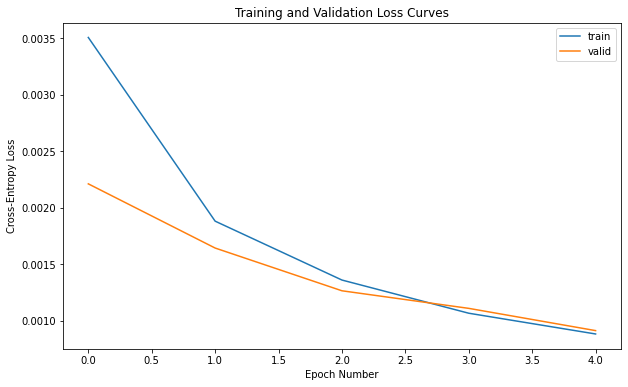

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_loss_history, label='train')
ax.plot(valid_loss_history, label='valid')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss Curves")
plt.legend();

# Check performance on unseen data
test_performance(model, test_data=test_dataset)